# Copied and converted with s/466/212/ and s/410/182/ on Feb 12, 2023

Then nrcb->nrcb on June 30, 2023

In [1]:
from photutils import CircularAperture, EPSFBuilder, find_peaks, CircularAnnulus
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup, IntegratedGaussianPRF, extract_stars, IterativelySubtractedPSFPhotometry, BasicPSFPhotometry

In [2]:
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter

In [3]:
from astropy import stats
from astropy.table import Table
from astropy.wcs import WCS

In [4]:
from astropy.io import fits

In [5]:
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm
from astropy import wcs
from astropy import table
from astropy import units as u
import pylab as pl
pl.rcParams['figure.facecolor'] = 'w'
pl.rcParams['image.origin'] = 'lower'

In [6]:
from astroquery.svo_fps import SvoFps

In [7]:
import numpy as np

In [8]:
import reproject

In [9]:
from astropy import units as u

In [10]:
basepath = '/orange/adamginsburg/jwst/brick/'

In [11]:
fh_212 = fits.open(f'{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-nrcb_realigned-to-refcat.fits')
fh_182 = fits.open(f'{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-nrcb_realigned-to-refcat.fits')

In [12]:
ww212 = wcs.WCS(fh_212['SCI'].header)
ww182 = wcs.WCS(fh_182['SCI'].header)

Set OBSGEO-B to   -20.667233 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526480076.188 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -20.648906 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526264739.299 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [13]:
instrument = fh_212[0].header['INSTRUME']
telescope = fh_212[0].header['TELESCOP']
filt212 = fh_212[0].header['FILTER']
print(filt212)
wavelength_table_212 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt212}')
filt182 = fh_182[0].header['FILTER']
print(filt182)
wavelength_table_182 = SvoFps.get_transmission_data(f'{telescope}/{instrument}.{filt182}')

F212N
F182M


In [14]:
filterlist = SvoFps.get_filter_list('JWST', instrument='NIRCam')
filterlist.add_index('filterID')

In [15]:
filterlist.loc['JWST/NIRCam.F212N']['WidthEff']

274.27440340689

In [16]:
filterlist.loc['JWST/NIRCam.F182M']['WidthEff']

2250.8124936959

In [17]:
fractional_bandwidth_212 = filterlist.loc['JWST/NIRCam.F212N']['WidthEff'] / filterlist.loc['JWST/NIRCam.F182M']['WidthEff']

In [18]:
data_212_proj_182,_ = reproject.reproject_exact(fh_212['SCI'], fh_182['SCI'].header)

/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [19]:
cont182_sub_paa = fits.getdata(f'{basepath}/images/F182_minus_F187_nrcb.fits')

In [20]:
f212_minus_cont = data_212_proj_182 - cont182_sub_paa #* fractional_bandwidth_212
fits.PrimaryHDU(data=f212_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F212_minus_F182cont_nrcb.fits', overwrite=True)

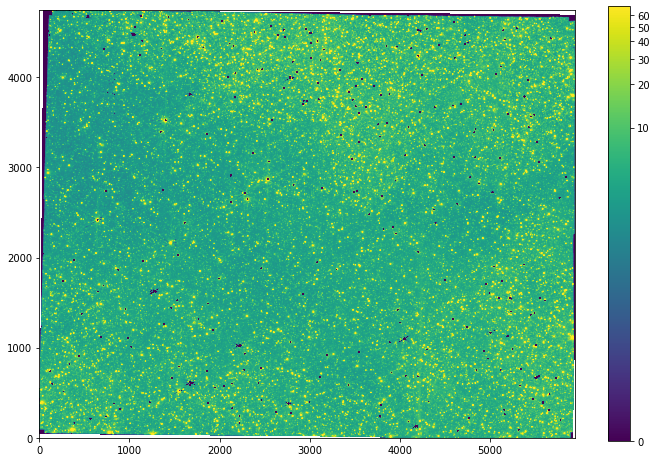

In [21]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

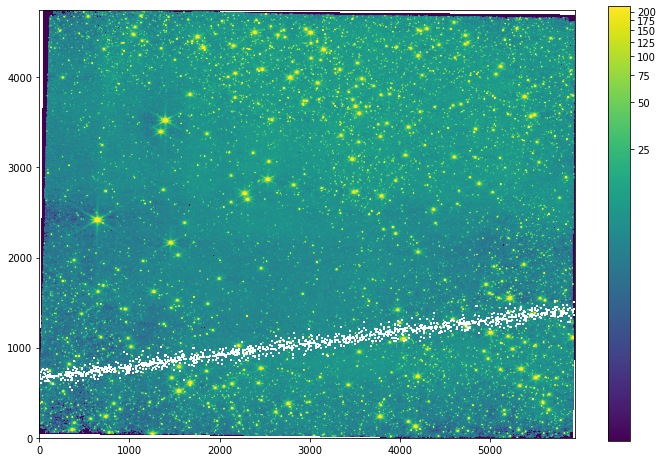

In [22]:
pl.figure(figsize=(12,8))
pl.imshow(f212_minus_cont, norm=simple_norm(f212_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [23]:
stars_f212 = DAOStarFinder(threshold=60, fwhm=2.302, peakmax=1e4)(fh_212['SCI'].data)
stars_f212['skycoord'] = ww212.pixel_to_world(stars_f212['xcentroid'], stars_f212['ycentroid'])
len(stars_f212)

37908

In [24]:
stars_182 = DAOStarFinder(threshold=10, fwhm=2.302, peakmax=900)(fh_182['SCI'].data)
stars_182['skycoord'] = ww182.pixel_to_world(stars_182['xcentroid'], stars_182['ycentroid'])
len(stars_182)

134402

In [25]:
matches, sep, _ = stars_f212['skycoord'].match_to_catalog_sky(stars_182['skycoord'], nthneighbor=1)

for cn in stars_f212.colnames:
    stars_f212.rename_column(cn, f"{cn}_212")
for cn in stars_182.colnames:
    stars_182.rename_column(cn, f"{cn}_182")
                         
stars_f212.add_column(name="sep_182_212", col=sep)
stars_f212.add_column(name="id_182_212", col=matches)
mergetbl = table.hstack([stars_f212, stars_182[matches]], join_type='exact')

(array([3.1656e+04, 3.7970e+03, 1.8530e+03, 4.0500e+02, 1.4000e+02,
        4.5000e+01, 7.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([5.55774789e-06, 1.07043801e-01, 2.14082044e-01, 3.21120287e-01,
        4.28158530e-01, 5.35196773e-01, 6.42235016e-01, 7.49273259e-01,
        8.56311503e-01, 9.63349746e-01, 1.07038799e+00]),
 <BarContainer object of 10 artists>)

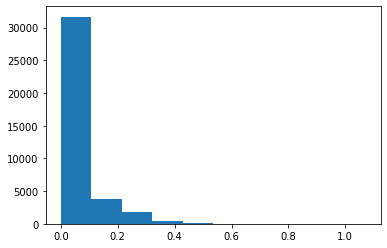

In [26]:
pl.hist(mergetbl['sep_182_212'].to(u.arcsec).value)

(-0.5, 0.5, -0.5, 0.5)

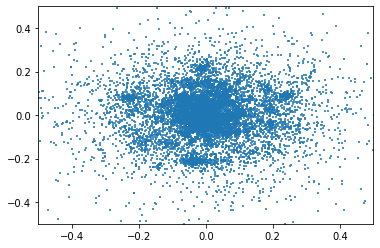

In [27]:
radiff = (mergetbl['skycoord_212'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_212'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
pl.scatter(radiff, decdiff, marker=',', s=1, alpha=0.8)
pl.axis([-0.5,0.5,-0.5,0.5])

(-0.05, 0.05, -0.05, 0.05)

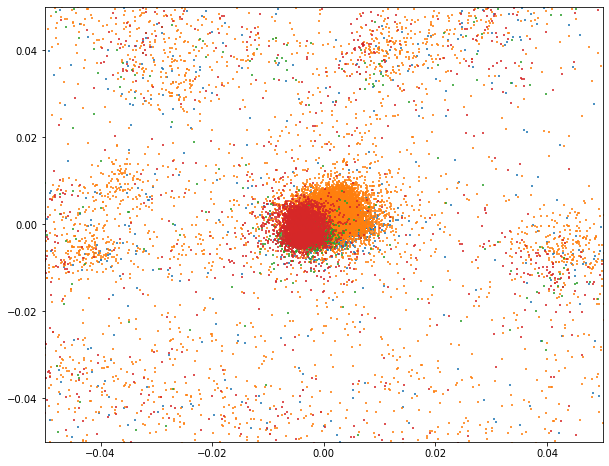

In [28]:
pl.figure(figsize=(10,8))
radiff = (mergetbl['skycoord_212'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_212'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
topleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] > 1024)
pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.8)
topright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] > 1024)
pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.8)
bottomleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] < 1024)
pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.8)
bottomright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] < 1024)
pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.8)
pl.axis([-0.05,0.05,-0.05,0.05])

In [29]:
mergetbl['xcentroid_212'].max(), mergetbl['ycentroid_212'].max()

(5938.47611886259, 4744.513258398327)

In [30]:
dist_from_center = ((mergetbl['xcentroid_212'] - 1450)**2 + (mergetbl['ycentroid_212'] - 1145)**2)**0.5

(0.0, 0.07)

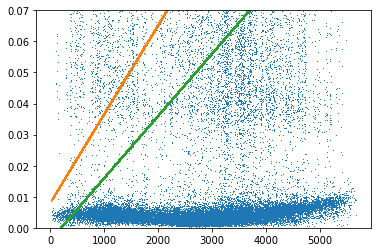

In [31]:
pl.plot(dist_from_center, mergetbl['sep_182_212'].to(u.arcsec).value, ',')
pl.plot(dist_from_center, dist_from_center/1750 * 0.050 + 0.008)
pl.plot(dist_from_center, dist_from_center/1750 * 0.035 - 0.004)
pl.ylim(0,0.07)

In [32]:
ok = (mergetbl['sep_182_212'] < 0.05*u.arcsec) & (mergetbl['sep_182_212'] < (dist_from_center/1750*0.05 +0.08) *u.arcsec) & (mergetbl['sep_182_212'] > (dist_from_center/1750*0.035 - 0.08) *u.arcsec)

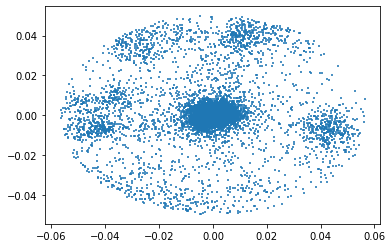

In [33]:
radiff = (mergetbl['skycoord_212'].ra - mergetbl['skycoord_182'].ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_212'].dec - mergetbl['skycoord_182'].dec).to(u.arcsec)
pl.scatter(radiff[ok], decdiff[ok], marker=',', s=1, alpha=0.8)

In [34]:
from astropy.wcs.utils import fit_wcs_from_points

In [35]:
ww_212_refit = fit_wcs_from_points([mergetbl['xcentroid_212'][ok], mergetbl['ycentroid_212'][ok]], mergetbl['skycoord_182'][ok], sip_degree=1)

In [36]:
ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_212'][ok], sip_degree=3)

In [37]:
skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])

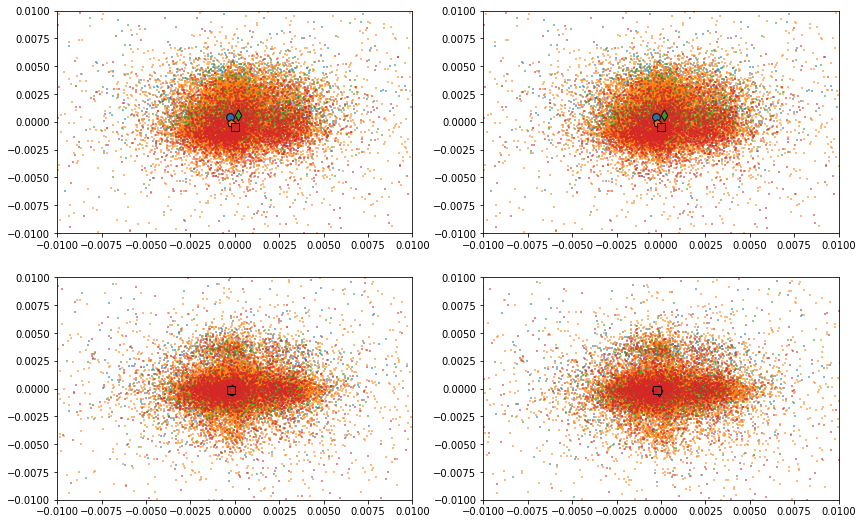

In [38]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok], mergetbl['ycentroid_182'][ok]], mergetbl['skycoord_212'][ok], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_212'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_212'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_182_refit = fit_wcs_from_points([mergetbl['xcentroid_182'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_182'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_212'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_182_refit = ww_182_refit.pixel_to_world(mergetbl['xcentroid_182'], mergetbl['ycentroid_182'])
    radiff = (mergetbl['skycoord_212'].ra - skycoord_182_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_212'].dec - skycoord_182_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

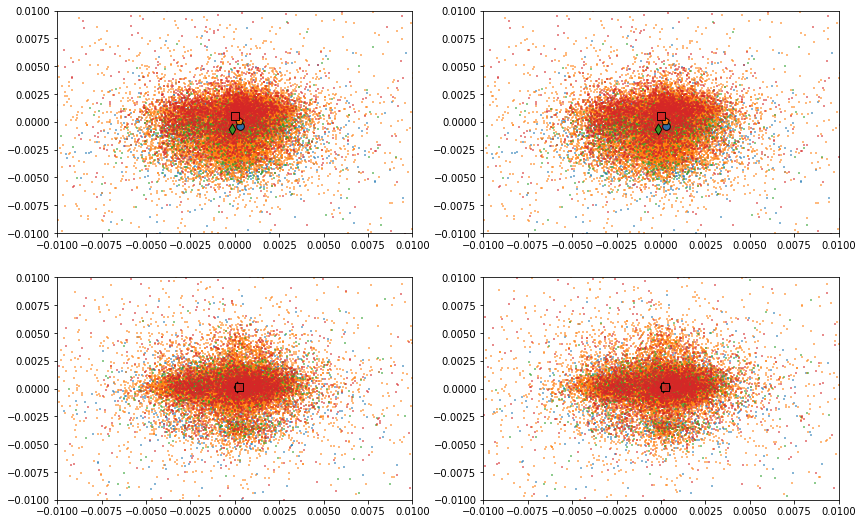

In [39]:
pl.figure(figsize=(14,9))
for sip_degree in (0,1,2,3):
    pl.subplot(2,2,sip_degree+1)
    
    ww_212_refit = fit_wcs_from_points([mergetbl['xcentroid_212'][ok], mergetbl['ycentroid_212'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
    skycoord_212_refit = ww_212_refit.pixel_to_world(mergetbl['xcentroid_212'], mergetbl['ycentroid_212'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_212_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_212_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    ww_212_refit = fit_wcs_from_points([mergetbl['xcentroid_212'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_212'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
    skycoord_212_refit = ww_212_refit.pixel_to_world(mergetbl['xcentroid_212'], mergetbl['ycentroid_212'])
    radiff = (mergetbl['skycoord_182'].ra - skycoord_212_refit.ra).to(u.arcsec)
    decdiff = (mergetbl['skycoord_182'].dec - skycoord_212_refit.dec).to(u.arcsec)
    sep = (radiff**2 + decdiff**2)**0.5
    
    topleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] > 1024)
    sc = pl.scatter(radiff[topleft], decdiff[topleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topleft]), np.median(decdiff[topleft]), marker='o', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    topright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] > 1024)
    sc = pl.scatter(radiff[topright], decdiff[topright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[topright]), np.median(decdiff[topright]), marker='p', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomleft = (mergetbl['xcentroid_212'] < 1424) & (mergetbl['ycentroid_212'] < 1024)
    sc = pl.scatter(radiff[bottomleft], decdiff[bottomleft], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomleft]), np.median(decdiff[bottomleft]), marker='d', alpha=0.9, c=sc.get_facecolors(), zorder=15, edgecolors='k', s=60)
    bottomright = (mergetbl['xcentroid_212'] > 1424) & (mergetbl['ycentroid_212'] < 1024)
    sc = pl.scatter(radiff[bottomright], decdiff[bottomright], marker=',', s=1, alpha=0.5)
    pl.scatter(np.median(radiff[bottomright]), np.median(decdiff[bottomright]), marker='s', alpha=0.9, c=sc.get_facecolors(), zorder=25, edgecolors='k', s=60)
    pl.axis([-0.01,0.01,-0.01,0.01])

In [40]:
sip_degree = 3
ww_212_refit = fit_wcs_from_points([mergetbl['xcentroid_212'][ok], mergetbl['ycentroid_212'][ok]], mergetbl['skycoord_182'][ok], sip_degree=sip_degree)
skycoord_212_refit = ww_212_refit.pixel_to_world(mergetbl['xcentroid_212'], mergetbl['ycentroid_212'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_212_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_212_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5
ww_212_refit = fit_wcs_from_points([mergetbl['xcentroid_212'][ok & (sep < 0.01*u.arcsec)], mergetbl['ycentroid_212'][ok & (sep < 0.01*u.arcsec)]], mergetbl['skycoord_182'][ok & (sep < 0.01*u.arcsec)], sip_degree=sip_degree)
skycoord_212_refit = ww_212_refit.pixel_to_world(mergetbl['xcentroid_212'], mergetbl['ycentroid_212'])
radiff = (mergetbl['skycoord_182'].ra - skycoord_212_refit.ra).to(u.arcsec)
decdiff = (mergetbl['skycoord_182'].dec - skycoord_212_refit.dec).to(u.arcsec)
sep = (radiff**2 + decdiff**2)**0.5

In [41]:
ww_212_refit.to_header(relax=True).totextfile(f'{basepath}/reduction/headers/f212n_nrcb_refitted_to_f182m.hdr', overwrite=True)

In [ ]:
data_212_proj_182_refit, overlap_refit = reproject.reproject_exact((fh_212['SCI'].data, ww_212_refit), fh_182['SCI'].header)

Set OBSGEO-B to   -20.648906 from OBSGEO-[XYZ].
Set OBSGEO-H to 1526264739.299 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
/blue/adamginsburg/adamginsburg/repos/reproject/reproject/spherical_intersect/core.py:47: UserWarning: The reproject_exact function currently has precision issues with images that have resolutions below ~0.05 arcsec, so the results may not be accurate.
  warnings.warn(


In [ ]:
fits.PrimaryHDU(data=data_212_proj_182_refit, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F212_refitted212wcsto182_nrcb.fits', overwrite=True)

In [ ]:
f212_minus_cont = data_212_proj_182_refit - cont182_sub_paa #* fractional_bandwidth_212
fits.PrimaryHDU(data=f212_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrcb.fits', overwrite=True)

In [ ]:
pl.figure(figsize=(12,8))
pl.imshow(cont182_sub_paa, norm=simple_norm(cont182_sub_paa, min_percent=1, max_percent=99, stretch='log'))
pl.colorbar()

In [ ]:
pl.figure(figsize=(12,8))
pl.imshow(f212_minus_cont, norm=simple_norm(f212_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()

In [ ]:
xr = np.linspace(0,15)
pl.scatter(mergetbl['flux_212'][ok], mergetbl['flux_182'][ok], s=1)
pl.plot(xr, xr/fractional_bandwidth_212, color='red')
scalefactor = 0.0867
pl.plot(xr, xr/scalefactor, color='orange')

In [ ]:
np.median(1/(mergetbl['flux_182'][ok]/mergetbl['flux_212'][ok]))

In [ ]:
pl.hist(1/(mergetbl['flux_182'][ok]/mergetbl['flux_212'][ok]), bins=np.linspace(0.05,0.25))
pl.axvline(scalefactor, color='orange')
pl.axvline(fractional_bandwidth_212, color='red')

In [ ]:
f212_minus_cont = data_212_proj_182_refit - 0.8*cont182_sub_paa #* fractional_bandwidth_212
fits.PrimaryHDU(data=f212_minus_cont, header=fh_182['SCI'].header).writeto(f'{basepath}/images/F212_minus_F182cont_refitted212wcsto182_nrcb.fits', overwrite=True)

In [ ]:
pl.figure(figsize=(12,8))
pl.imshow(f212_minus_cont, norm=simple_norm(f212_minus_cont, min_percent=4, max_percent=99.5, stretch='log'))
pl.colorbar()